In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time

import astropy.units as u
import astropy.constants as const

from astroquery.mast import Catalogs

import starry

starry.config.lazy = False
starry.config.quiet = True

# ipywidgets

In [2]:
# import my DIY RV light curve
rv_data = pd.read_csv('./rmrv_lc_b_0.0_phi_0.0pi.csv', 
                      header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])

In [52]:
# import McQuillen rotation period info! 
# https://arxiv.org/pdf/1402.5694.pdf
# Teff and log g are from the KIC or, where available, from
# Dressing & Charbonneau (2013), indicated by a DC value of 1. The mass, M , was derived from Teff using the isochrones of
# Baraffe et al. (1998). The remaining columns are: period, Prot, and period error, σP; the average amplitude of variability
# within one period, Rper; the local peak height, LPH; and the assigned weight, w. The Flag column indicates whether fault
# correction (‘BQR’), soft smoothing (‘SM1’) or hard smoothing (‘SM2’) were required to detect a period (

vrot_data = pd.read_csv('./mcquillen_Table_1_Periodic.txt')   # McQuillen et al
vrot_kid = vrot_data['KID']  # get Kepler IDs from rotation period data
vrot_data.head()

,KID,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


In [5]:
# Import KOI list!
koi_list = pd.read_csv('./cfop_targets.csv', header=17)
koi_list['KID'] = koi_list['KICID']
koi_list.head()

,Star,KICID,KepName,#KOIs-CP,#KOIs-PC,#KOIs-FP,#KOIs-ND,#KOIs-TOT,RA,Dec,mKep,mKs,NumStel,NumPlan,spec_num,img_num,rv_num,LastMod,KID
0,1,11446443,Kepler-1,1,0,0,0,1,19:07:14.03,49:18:59.04,11.338,9.846,13,3,2,10,0,2017-06-18 23:13:40,11446443
1,2,10666592,Kepler-2,1,0,0,0,1,19:28:59.35,47:58:10.28,10.463,9.334,13,3,1,3,0,2017-06-18 23:13:40,10666592
2,3,10748390,Kepler-3,1,0,0,0,1,19:50:50.24,48:04:51.07,9.174,7.009,10,3,1,5,0,2017-11-21 10:13:46,10748390
3,4,3861595,Kepler-1658,1,0,0,0,1,19:37:25.57,38:56:50.57,11.432,10.195,21,3,7,5,0,2019-03-05 11:04:20,3861595
4,5,8554498,NaN,0,2,0,0,2,19:18:57.53,44:38:50.71,11.665,10.213,20,6,32,9,0,2017-04-20 13:40:08,8554498


In [8]:
# merge KOI list with McQuillen rotation period list
koi_vrot_match = pd.merge(koi_list, vrot_data, on='KID')

In [37]:
# select M dwarfs
smol_beans = koi_vrot_match[(koi_vrot_match['Mass'] < 0.5) & (koi_vrot_match['#KOIs-FP'] != 1)]
print(f"we have {len(smol_beans)} M dwarfs which are not KOI FPs")

we have 11 M dwarfs which are not KOI FPs


In [38]:
smol_beans.to_csv("./mdwarf_kois_with_vrot.csv")

In [44]:
# added KOI planet periods in Gdoc
df = pd.read_csv("./vsini_cutie_pies_koi_vrot_match.csv")

In [51]:
df.loc[~df['Period'].isna()]

,Star,KICID,KepName,#KOIs-CP,#KOIs-PC,#KOIs-FP,#KOIs-ND,#KOIs-TOT,RA,Dec,...,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag,Period,Exofop
1,5228,6036286,NaN,0,1,0,0,1,19:19:16,41:23:47,...,0.3292,53.528,0.243,12326.96,1.275,0.5893,1,---,546.533090,https://exofop.ipac.caltech.edu/tess/target.ph...
2,6276,2557350,NaN,0,1,0,0,1,19:07:17,37:51:32,...,0.4001,18.979,0.072,8548.20,1.028,0.5792,1,---,3.098728,https://exofop.ipac.caltech.edu/tess/target.ph...
3,6635,5951140,NaN,0,1,0,0,1,19:15:33,41:14:48,...,0.3808,5.232,0.012,45202.17,1.538,0.7343,1,---,0.527401,https://exofop.ipac.caltech.edu/tess/target.ph...
4,6863,7350067,Kepler-1646,1,0,0,0,1,19:10:06,42:54:46,...,0.2619,3.514,0.006,48054.81,1.540,0.7205,1,---,4.485592,https://exofop.ipac.caltech.edu/tess/target.ph...


# activities

In [238]:
# import existing kic ids
match1 = pd.read_csv('./kic_tic_lookup_pt1.csv')
matchtic1 = match1['TIC ID']

In [240]:
# KIC-TIC pairs
lookup_table = pd.concat([vrot_kid, matchtic1], axis=1)

In [220]:
# df =  pd.DataFrame(np.zeros(len(vrot_data)), columns=['TIC ID'], dtype='int64')

In [221]:
# astroquery
# TIC fields: https://mast.stsci.edu/api/v0/_t_i_cfields.html

i=0

# df = pd.DataFrame(np.zeros(len(vrot_data)), columns=['TIC ID'], dtype='int64')

# look up TIC ID for each KIC ID 
for i in range(len(vrot_data)):
    time.sleep(1) # please don't time out
    
    # query mast for TIC ID
    kid = vrot_data.loc[i, 'KID']
    print(f"{i} / {len(vrot_data)} targets matched. KIC ID = {kid}")
    table = Catalogs.query_criteria(catalog='Tic', KIC=str(kid), radius=1)
    ticid = table['ID'][0]
    
    # save tic id that we get
    df.iloc[i,0] = ticid
    
    i +=1 

0 / 34030 targets matched. KIC ID = 892376
1 / 34030 targets matched. KIC ID = 1026146
2 / 34030 targets matched. KIC ID = 1026474
3 / 34030 targets matched. KIC ID = 1162635
4 / 34030 targets matched. KIC ID = 1164102
5 / 34030 targets matched. KIC ID = 1292688
6 / 34030 targets matched. KIC ID = 1297303
7 / 34030 targets matched. KIC ID = 1429921
8 / 34030 targets matched. KIC ID = 1430349
9 / 34030 targets matched. KIC ID = 1430893
10 / 34030 targets matched. KIC ID = 1431060
11 / 34030 targets matched. KIC ID = 1431116
12 / 34030 targets matched. KIC ID = 1432700
13 / 34030 targets matched. KIC ID = 1432745
14 / 34030 targets matched. KIC ID = 1435229
15 / 34030 targets matched. KIC ID = 1569682
16 / 34030 targets matched. KIC ID = 1569863
17 / 34030 targets matched. KIC ID = 1570915
18 / 34030 targets matched. KIC ID = 1571364
19 / 34030 targets matched. KIC ID = 1572802
20 / 34030 targets matched. KIC ID = 1573478
21 / 34030 targets matched. KIC ID = 1577265
22 / 34030 targets ma

ReadTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Read timed out. (read timeout=None)

In [222]:
# save to CSV 

# df.to_csv('kic_tic_lookup.csv')

In [26]:
t = np.array(rv_data['time [d]']) * u.d
myrv = np.array(rv_data['rv [m/s]']) * u.m / u.s

P = 20 * u.d


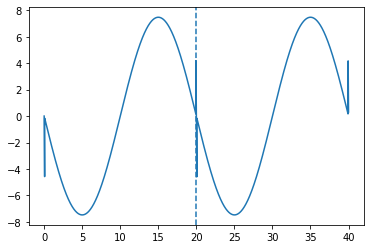

In [27]:
plt.plot(t, myrv)
plt.axvline(P.value, linestyle='--')


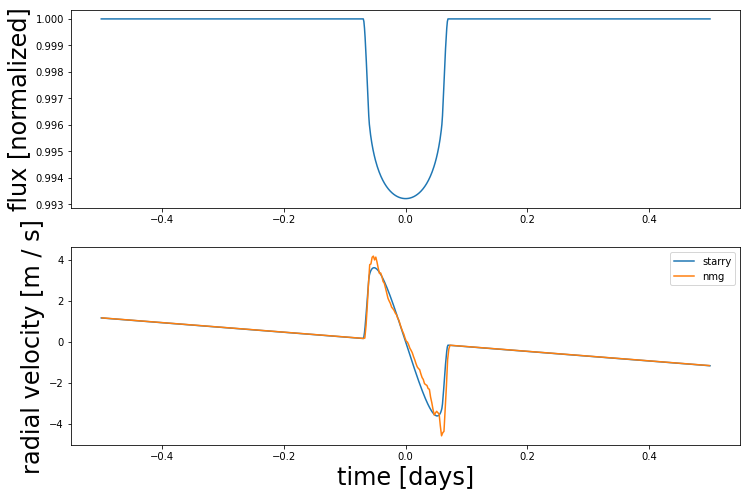

In [41]:
# Define the star
# https://starry.readthedocs.io/en/latest/notebooks/RossiterMcLaughlin/ 
A = starry.Primary(
    #starry.Map(udeg=2, rv=True, amp=1, veq=5e4, alpha=0, obl=30),
    starry.Map(udeg=2, rv=True, amp=1, veq=850, alpha=0, oblate=False),
    r=0.5,
    m=0.5,
    length_unit=u.Rsun,
    mass_unit=u.Msun,
)

# limb darkening coefficients
A.map[1] = 0.5
A.map[2] = 0.25

# Define the planet
b = starry.Secondary(
    starry.Map(rv=True, amp=0, veq=0),
    r=4.,
    porb=20.0,
    m=20.,
    t0=0.0,
    inc=90., # 80.0,
    ecc=0., # 0.3,
    w=0, #90, # 60,
    length_unit=u.Rearth,
    mass_unit=u.Mearth,
    angle_unit=u.degree,
    time_unit=u.day,
)

# Define the system
sys = starry.System(A, b)

# Compute the flux & RV signal
time = np.linspace(-0.5, 0.5, 1000)
flux = sys.flux(time)
rv = sys.rv(time)

# select small section of my RV curve
shiftt = t - P
cropt = shiftt[(shiftt.value < 0.5) & (shiftt.value > -0.5)]
croprv = myrv[(shiftt.value < 0.5) & (shiftt.value > -0.5)]

# Plot it
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(time, flux)
ax[1].plot(time, rv, label='starry')
ax[1].plot(cropt, croprv, label='nmg')
ax[1].set_xlabel("time [days]", fontsize=24)
ax[0].set_ylabel("flux [normalized]", fontsize=24)
ax[1].set_ylabel("radial velocity [m / s]", fontsize=24);
plt.legend()